In [1]:
import spotipy
from spotipy import SpotifyClientCredentials
import sys
sys.path.append('src')
import numpy as np
import mosaic_maker

In [2]:
CLIENT_ID = '###'
CLIENT_SECRET = '###'

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID,
                                                           client_secret=CLIENT_SECRET))
mm = mosaic_maker.MosaicMaker(sp)

In [3]:
mm.get_albums('src/album_list.csv')

In [4]:
mosaic = mm.create_mosaic()

In [5]:
import joblib

joblib.dump(mosaic, 'mosaic.pkl')

['mosaic.pkl']

# Analysing Mosaic

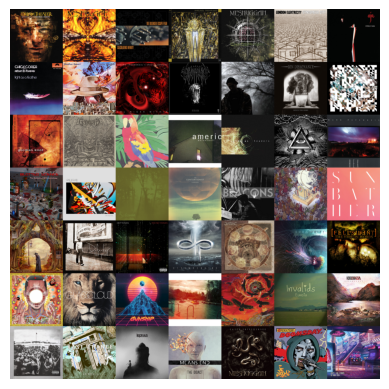

In [6]:
import joblib
import matplotlib.pyplot as plt

mosaic = joblib.load('mosaic.pkl')
plt.figure()
plt.imshow(mosaic)
plt.axis(False)
plt.show()

In [7]:
import PIL
from PIL.Image import Resampling
import cv2

all_art = []
for i in range(len(mm.album_list)):
    cover = mm.album_list[i].artwork.resize((3, 3), Resampling.BICUBIC)
    #cover = cover.convert('HSV')
    cover = cv2.cvtColor(np.array(cover), cv2.COLOR_RGB2LAB)
    cover = np.ravel(cover)
    all_art += [cover]

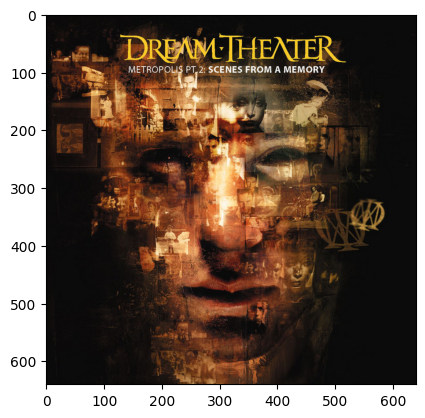

In [8]:
plt.figure()
plt.imshow(mm.album_list[0].artwork)
plt.show()


In [9]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

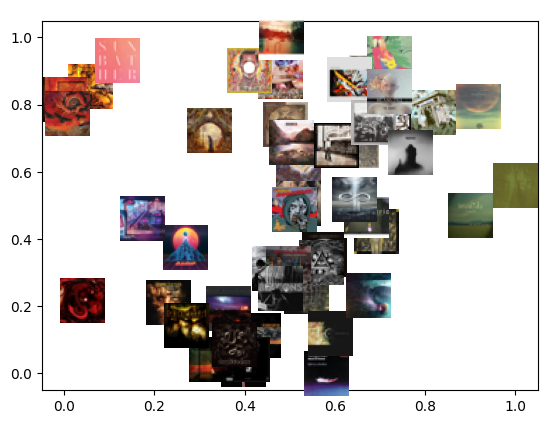

In [124]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

all_art_norm = MinMaxScaler().fit_transform(all_art)
# embedding = PCA(n_components=2).fit_transform(all_art_norm)
embedding = TSNE(n_components=2).fit_transform(all_art_norm)
embedding = MinMaxScaler().fit_transform(embedding)
plt.figure()
for i in range(len(mm.album_list)):
    x = embedding[i, 0]
    y = embedding[i, 1]
    imscatter(x, y, np.array(mm.album_list[i].artwork.resize((32, 32))))
plt.show()


In [62]:
from sklearn.neighbors import KDTree

kd = KDTree(embedding)
k = 49
dist, ind = kd.query(embedding, k=k)

In [66]:
kd.query(np.array([0, 0]).reshape(1, -1), k=2)

(array([[0.21889561, 0.30464841]]), array([[ 9, 34]]))

In [11]:
from sklearn.neighbors import KDTree

kd = KDTree(embedding)
k = 49
dist, ind = kd.query(embedding, k=k)

for i in range(49):
    plt.figure()
    for j in range(5):
        plt.subplot(1,k,j+1)
        plt.imshow(mm.album_list[ind[i, j]].artwork.resize((32, 32)))
        plt.axis(False)
    plt.show()


# Tiling Images

Interpolate to grid

In [151]:
x = np.linspace(0, 1, 7)
y = np.linspace(0, 1, 7)
image_mat = np.zeros((7, 7), dtype=int)
embedding2 = embedding
kd = KDTree(embedding2)

album_inds = np.arange(0, 49)

for i in range(7):
    for j in range(7):
        _, ind = kd.query(np.array([y[j], x[i]]).reshape(1, -1), k=1)
        image_mat[i, j] = album_inds[ind[0][0]]
        embedding2 = np.delete(embedding2, ind[0][0], axis=0)
        album_inds = np.delete(album_inds, ind[0][0])
        if len(embedding2) > 0:
            kd = KDTree(embedding2)
    

In [152]:
image_mat

array([[ 9, 30,  6,  7, 18, 33, 40],
       [ 0, 34, 20,  4, 19,  3, 23],
       [48, 37, 11, 21, 12, 17, 44],
       [39, 28, 47, 36, 31, 15, 24],
       [14,  1, 41, 26, 29, 43, 13],
       [27, 35,  8, 32,  5, 45, 16],
       [38, 22, 42, 25,  2, 46, 10]])

Zigzag

In [157]:
def zigzag(n):
    '''zigzag rows'''
    def compare(xy):
        x, y = xy
        return (x + y, -y if (x + y) % 2 else y)
    xs = range(n)
    return {index: n for n, index in enumerate(sorted(
        ((x, y) for x in xs for y in xs),
        key=compare
    ))}


In [158]:
zz = zigzag(7)

In [160]:
image_mat = np.zeros((7, 7), dtype=int)
ind_list = np.arange(0, len(mm.album_list))
start = np.random.choice(ind_list)
for i in range(7):
    for j in range(7):
        ind_zz = zz[(i, j)]
        image_mat[i, j] = ind[start, ind_zz].astype(int)

IndexError: index 44 is out of bounds for axis 0 with size 1

In [162]:
from PIL import Image

mosaic = Image.new("RGB", (7 * 640, 7 * 640), (0, 0, 0))
x = 0
y = 0
for i in image_mat.ravel():
    im = mm.album_list[i]
    mosaic.paste(
        im.artwork.resize((640, 640), Image.Resampling.BICUBIC), (x, y)
    )
    x += 640
    if x >= 7 * 640:
        x = 0
        y += 640

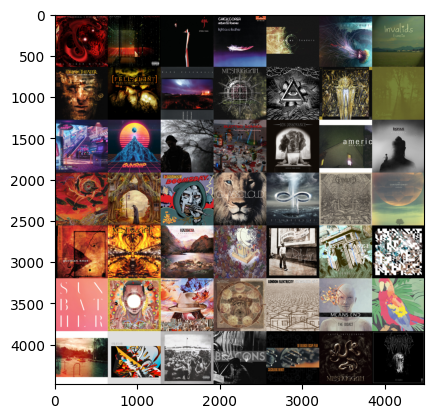

In [161]:
plt.figure()
plt.imshow(mosaic)
plt.show()